<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/19_molecular_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab

    !pip install condacolab
    import condacolab

    condacolab.install()
except ModuleNotFoundError:
    pass

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [2]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output

    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm openmmforcefields openff-toolkit pdbfixer pypdb rdkit
except ModuleNotFoundError:
    on_colab = False
else:
    # check if installation was succesful
    try:
        import rdkit

        on_colab = True
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

Dependencies successfully installed!


In [3]:
import sys

if not on_colab and sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c conda-forge openmmforcefields
    # Notes:
    # - If you do not have mamba installed, install it or use conda instead
    # - Under MacOS with an M1 chip you may need to use
    #   CONDA_SUBDIR=osx-64 in front of the above command

In [4]:
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [30]:
pdbid = "3POZ"
ligand_name = "03P"
pdb_path = f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

In [31]:
r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

prepare protein

In [32]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                del fixer.missingResidues[key]

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [33]:
# prepare protein and build only missing non-terminal residues

prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)

prepare ligand

In [34]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

[17:28:45] WARNING: More than one matching pattern found - picking one



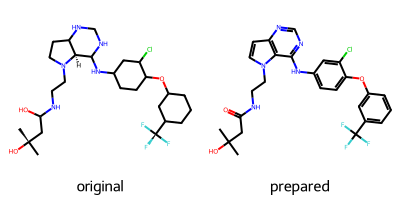

In [35]:
smiles = "CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)C(F)(F)F)c(Cl)c3)c12"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)

In [36]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [37]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

In [38]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [39]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/usr/local/lib/python3.10/site-packages/openmm/unit/quantity.py:750: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [58]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5561 atoms.


In [41]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [42]:
forcefield = generate_forcefield(rdkit_ligand)

In [43]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

In [44]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [45]:
simulation.minimizeEnergy()
with open("topology.pdb", "w") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
        file=pdb_file,
        keepIds=True,
    )

In [55]:
# output settings
if on_colab:
    steps = 500  # corresponds to 100 ps
    write_interval = 50  # write every 10 ps
    log_interval = 25  # log progress to stdout every 5 ps
else:
    steps = 100  # corresponds to 20 fs
    write_interval = 10  # write every 2 fs
    log_interval = 10  # log progress to stdout every 2 fs
simulation.reporters.append(
    md.reporters.XTCReporter(file=str("trajectory.xtc"), reportInterval=write_interval)
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [56]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)  # perform the simulation

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
275.0%	1375	-820069.5917694856	300.70801789383444	0	--
280.0%	1400	-819983.1464936219	300.0918382591453	0.81	23:56:49
285.0%	1425	-819263.0368271468	298.8138801747044	0.866	23:56:56
290.0%	1450	-818919.0744361738	298.8305427291525	0.725	23:56:14
295.0%	1475	-819748.4363111855	300.729636904383	0.647	23:55:40
300.0%	1500	-819660.1624241127	299.66761221053065	0.687	23:55:49
305.0%	1525	-819323.6770758838	299.71689710004654	0.683	23:55:41
310.0%	1550	-819539.2441378905	300.3312551362554	0.657	23:55:24
315.0%	1575	-819116.2467783571	299.9009869911623	0.683	23:55:29
320.0%	1600	-818403.6001041392	298.94589120878936	0.706	23:55:31
325.0%	1625	-818228.2611690544	299.15140107215495	0.68	23:55:15
330.0%	1650	-818716.549979551	300.31481806182217	0.68	23:55:08
335.0%	1675	-818214.4521257979	298.8141444495686	0.697	23:55:09
340.0%	1700	-818554.5553893867	299.4424987187032	0.702	23:55:05
345.0%	17

In [57]:
if on_colab:
    files.download("topology.pdb")
    files.download("trajectory.xtc")

FileNotFoundError: ignored